In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import seaborn as sns
import ipywidgets as widgets

# Import data

## Trading 

In [46]:
trading_results_df = pd.read_parquet('../../Results/trading_results/results.parquet')
trading_returns_df = pd.read_parquet('../../Results/trading_results/returns.parquet')
trading_weights_df = pd.read_parquet('../../Results/trading_results/weights.parquet')

## BBG data

In [47]:
bbg_df = pd.read_stata('../../data/calendars/bbg_96_18_econrelease.dta')
bbg_df

,Date,Time,Country,Event,Ticker,Period,Relevance,Survey,Actual,Prior,Revised,Units
0,1996-10-31,08:30,US,Personal Income,PITLCHNG Index,Sep,85.71430,0.006,0.006,0.006,NaN,
1,1996-10-31,08:30,US,US Personal Outlays SA,PIDSSO Index,Sep,0.00000,0.003,0.001,0.006,NaN,
2,1996-11-01,10:00,US,ISM Manufacturing,NAPMPMI Index,Oct,96.03170,50.900,50.200,51.700,NaN,
3,1996-11-01,10:00,US,Factory Orders,TMNOCHNG Index,Sep,87.30160,0.027,0.027,-0.019,NaN,
4,1996-11-04,10:00,US,Construction Spending,VNCCTOT Index,Sep,0.00000,-0.100,-1.100,0.900,NaN,$
...,...,...,...,...,...,...,...,...,...,...,...,...
24681,2018-12-28,10:00,US,Pending Home Sales NSA YoY,USPHTYOY Index,Nov,28.34650,NaN,NaN,NaN,NaN,
24682,2018-12-28,08:30,US,Advance Goods Trade Balance,USTGTTCB Index,Nov,7.08661,NaN,NaN,NaN,NaN,
24683,2018-12-28,08:30,US,Retail Inventories MoM,RSRSTMOM Index,Nov,3.93701,NaN,NaN,NaN,NaN,
24684,2018-12-31,09:45,US,Chicago Purchasing Manager,CHPMINDX Index,Dec,81.88980,NaN,NaN,NaN,NaN,


# Analysis

In [48]:
## Returns around FOMC announcements
trading_strategies_models = [('Benchmark', 'Market'), ('Lasso_PCA_select', 'MS Strategy 0.5')]

## Event study

In [62]:
## Set up FOMC Event dataframe
# Pick events
bbg_events_df = bbg_df.loc[bbg_df['Event'].str.contains('FOMC', regex=True)].copy()
# bbg_events_df = bbg_events_df.loc[(bbg_events_df['Time'] < '16:00') & (bbg_events_df['Time'] > '09:30')]
# bbg_events_df = bbg_df.query('Time == "10:00"').copy()

# Clean up
bbg_events_df['datetime'] = pd.to_datetime(bbg_events_df['Date'].astype(str) + ' ' + bbg_events_df['Time'].astype(str), errors = 'coerce')
bbg_events_df['datetime_rounded'] = pd.to_datetime(bbg_events_df['datetime']).dt.ceil('15min')
bbg_events_df['is_intraday'] = (bbg_events_df['datetime'].dt.time < dt.time(16,0)) & (bbg_events_df['datetime'].dt.time > dt.time(9,30))
# bbg_events_df = bbg_events_df.query('is_intraday == True').drop_duplicates(['datetime'])

# View
bbg_events_df.sort_values(by = 'Time')

,Date,Time,Country,Event,Ticker,Period,Relevance,Survey,Actual,Prior,Revised,Units,datetime,datetime_rounded,is_intraday
13481,2012-01-03,00:00,US,FOMC Meeting Minutes,FEDMMINU Index,13-Dec,1.5873,NaN,NaN,NaN,NaN,,2012-01-03 00:00:00,2012-01-03 00:00:00,False
9383,2008-10-08,07:00,US,FOMC Rate Decision (Upper Bound),FDTR Index,8-Oct,97.6190,NaN,0.0150,0.0200,NaN,,2008-10-08 07:00:00,2008-10-08 07:00:00,False
8537,2008-01-22,08:20,US,FOMC Rate Decision (Upper Bound),FDTR Index,22-Jan,97.6190,NaN,0.0350,0.0450,NaN,,2008-01-22 08:20:00,2008-01-22 08:30:00,False
2733,2001-09-17,08:20,US,FOMC Rate Decision (Upper Bound),FDTR Index,17-Sep,97.6190,NaN,0.0300,0.0350,NaN,,2001-09-17 08:20:00,2001-09-17 08:30:00,False
2467,2001-04-18,10:55,US,FOMC Rate Decision (Upper Bound),FDTR Index,18-Apr,97.6190,NaN,0.0450,0.0500,NaN,,2001-04-18 10:55:00,2001-04-18 11:00:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3613,2003-01-29,14:16,US,FOMC Rate Decision (Upper Bound),FDTR Index,29-Jan,97.6190,0.0125,0.0125,0.0125,NaN,,2003-01-29 14:16:00,2003-01-29 14:30:00,True
9441,2008-10-29,14:17,US,FOMC Rate Decision (Upper Bound),FDTR Index,29-Oct,97.6190,0.0100,0.0100,0.0150,NaN,,2008-10-29 14:17:00,2008-10-29 14:30:00,True
4106,2003-09-16,14:19,US,FOMC Rate Decision (Upper Bound),FDTR Index,16-Sep,97.6190,0.0100,0.0100,0.0100,NaN,,2003-09-16 14:19:00,2003-09-16 14:30:00,True
2823,2001-11-06,14:20,US,FOMC Rate Decision (Upper Bound),FDTR Index,6-Nov,97.6190,0.0200,0.0200,0.0250,NaN,,2001-11-06 14:20:00,2001-11-06 14:30:00,True


In [63]:
def plot_helper(fig, ax, trading_returns_df, trading_strategy_model):

    # Label
    series_label = " - ".join(trading_strategy_model)

    # Trading returns
    tr_ret_df = (
        trading_returns_df[trading_strategy_model]
        .rename(series_label)
        .to_frame()
        .copy()
        .assign(
            bbg_dates=pd.to_datetime(trading_returns_df.index.date).isin(
                bbg_events_df["datetime"].dt.date
            )
        )
    )
    tr_ret_df["date"] = tr_ret_df.index.date
    tr_ret_df["time"] = tr_ret_df.index.time
    tr_ret_df = tr_ret_df.loc[tr_ret_df.index.time != dt.time(9, 30)]
    bbg_dates = tr_ret_df.query("bbg_dates == True")["date"].unique()
    tr_ret_pivot_df = tr_ret_df.pivot(index="time", columns="date", values=[series_label])

    ## Plot
    # Figure
    fig, ax = plt.subplots(figsize=(20, 6), ncols=1)

    # Returns
    sns.pointplot(x = 'time', y = series_label, hue = 'bbg_dates', alpha = 0.8, ci = 90, data = tr_ret_df)
    ax.set_title(f"Trading Strategy Returns\n{series_label}")
    ax.xaxis.set_major_locator(mtick.MultipleLocator(2))
    ax.legend()

In [64]:
fig = plt.figure(figsize=(18, 5))
axes = fig.add_subplot(111)
axes2 = fig.add_subplot(211)
plt.close()
# hfig = display(fig, display_id=True)

def draw():
    #fig.clf()
    # axes.plot(values, [v*v for v in values])
    # axes.grid(False)
    # axes.set_ylabel('Return (%)')
    # fig.canvas.draw();
    # hfig.update(fig);
    # time.sleep(1)
    pass

def update(strategy = 'Benchmark', model = 'Market'):
    
    # Vars
    trading_strategy_model = (strategy, model)
    
    # Update plot
    axes.cla()
    axes2.cla()
    plot_helper(fig, axes, trading_returns_df, trading_strategy_model)
    plot_helper(fig, axes2, trading_weights_df, trading_strategy_model)
    # fig.canvas.draw();
    # hfig.update(fig);
    plt.show()
    

# update('Benchmark', 'Market')

strategy_selector = widgets.Dropdown(
    options=pd.unique(trading_returns_df.columns.get_level_values(0)),
    value='Benchmark',
    description='Strategy:',
)
model_selector = widgets.Dropdown(
    options=pd.unique(trading_returns_df.columns.get_level_values(1)),
    value='Market',
    description='Model:',
)
widgets.interact(update, strategy =strategy_selector, model = model_selector);

interactive(children=(Dropdown(description='Strategy:', options=('Benchmark', 'LR', 'LR_PCA_select', 'LR_Lasso…

In [13]:
tr_ret_pivot_df

Benchmark - Market                                              \
date             1998-01-02 1998-01-05 1998-01-06 1998-01-07 1998-01-08   
time                                                                      
09:45:00           0.001479  -0.002460   0.000873  -0.001347  -0.001964   
10:00:00          -0.003075   0.000554  -0.000494   0.001805   0.001907   
10:15:00          -0.003297   0.002641  -0.000777  -0.001813  -0.000856   
10:30:00           0.000682  -0.000552  -0.000388  -0.001426  -0.001836   
10:45:00           0.000722   0.001212  -0.000609  -0.001222  -0.000401   
11:00:00           0.000693  -0.000266   0.001014  -0.001204   0.001737   
11:15:00           0.000769   0.000256  -0.001094  -0.001428   0.000864   
11:30:00          -0.000650  -0.000006  -0.000569   0.000545   0.001553   
11:45:00          -0.000543   0.000731  -0.000405   0.000566  -0.000635   
12:00:00          -0.000048   0.001877  -0.001968   0.000059  -0.001131   
12:15:00           0.000825  -0.000676   0.000785  -0.001428  -0.000325   
12:30:00           0.000239  -0.000369  -0.000413  -0.000446   0.000165   
12:45:00           0.000724  -0.001029  -0.000113  -0.000733  -0.001067   
13:00:00          -0.000028   0.000007   0.000744  -0.000629  -0.000392   
13:15:00          -0.000116  -0.001983  -0.000410  -0.000997   0.000626   
13:30:00          -0.000246  -0.000015   0.000670   0.001140  -0.000354   
13:45:00          -0.000335  -0.000318   0.001355   0.000765  -0.000802   
14:00:00          -0.000766  -0.002160   0.001007   0.001668   0.001881   
14:15:00          -0.000266  -0.002894   0.000243   0.000357   0.000253   
14:30:00          -0.001056   0.000234  -0.001724  -0.000926   0.000730   
14:45:00          -0.000822   0.000722  -0.000915   0.001455  -0.001477   
15:00:00           0.000276   0.001541   0.000332   0.000592   0.000757   
15:15:00           0.000817   0.000517  -0.000676   0.001655   0.000542   
15:30:00           0.001789  -0.001286  -0.002235  -0.001763  -0.002015   
15:45:00           0.000612  -0.000954   0.000680  -0.000548  -0.001078   
16:00:00           0.003644   0.004003   0.001268   0.005782  -0.000746   

                                                                 ...  \
date     1998-01-09 1998-01-12 1998-01-13 1998-01-14 1998-01-15  ...   
time                                                             ...   
09:45:00  -0.003192   0.000805   0.000936  -0.002752  -0.000896  ...   
10:00:00  -0.001285   0.012029   0.000681  -0.000694  -0.000916  ...   
10:15:00  -0.003294   0.001374   0.000874   0.001263   0.000178  ...   
10:30:00   0.001331   0.000840  -0.002929  -0.002815  -0.000483  ...   
10:45:00   0.001045  -0.001515   0.001837   0.000510   0.001362  ...   
11:00:00  -0.000713   0.002520  -0.000290   0.000401  -0.000110  ...   
11:15:00  -0.000507   0.001335  -0.000544   0.000761   0.001080  ...   
11:30:00  -0.001150   0.005181   0.000194  -0.001615   0.000305  ...   
11:45:00  -0.005556  -0.002364   0.001311  -0.000290  -0.000554  ...   
12:00:00   0.000881   0.000726   0.000570  -0.000763  -0.001092  ...   
12:15:00   0.000847  -0.000527   0.001234   0.001385  -0.000361  ...   
12:30:00  -0.002195   0.000252  -0.000228  -0.000043  -0.000163  ...   
12:45:00  -0.000702   0.000490  -0.000241  -0.000424  -0.001200  ...   
13:00:00   0.001137   0.001009   0.000490   0.000872   0.000002  ...   
13:15:00   0.001952   0.002280   0.000195   0.001078  -0.000544  ...   
13:30:00  -0.001050  -0.000286  -0.001303   0.000099   0.001074  ...   
13:45:00  -0.000444  -0.000958   0.000297   0.000623   0.000775  ...   
14:00:00  -0.003761  -0.000054   0.000459  -0.000500  -0.000582  ...   
14:15:00  -0.003551  -0.001465   0.002396  -0.000624   0.000117  ...   
14:30:00   0.000696  -0.003084   0.000290   0.001997  -0.000832  ...   
14:45:00   0.001033   0.000151   0.000276   0.000561   0.000666  ...   
15:00:00   0.000833  -0.000832  -0.000285   0.000402   0.000705  ...   
15:15:00  -0.002169   0.004595  -

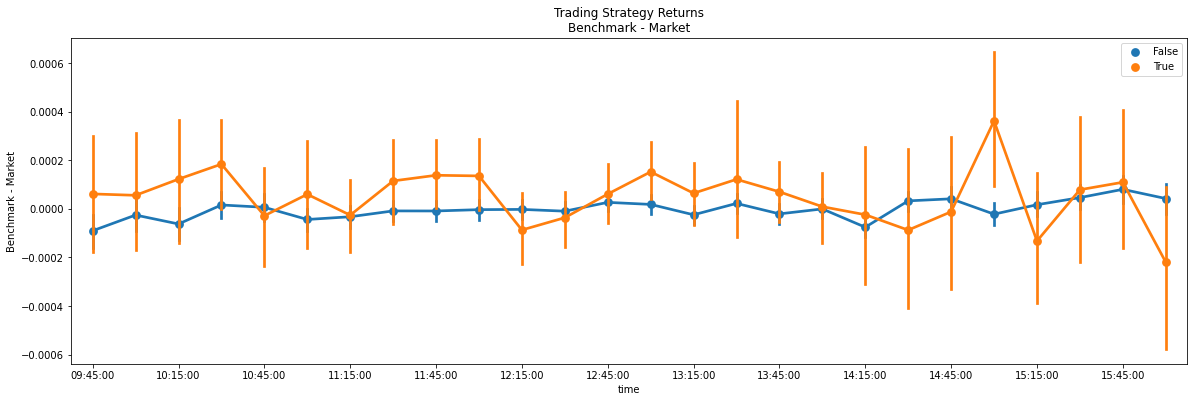

In [11]:
# Define strategy+model
trading_strategy_model = trading_strategies_models[0]
series_label = " - ".join(trading_strategy_model)

# Trading returns
tr_ret_df = (
    trading_returns_df[trading_strategy_model]
    .rename(series_label)
    .to_frame()
    .copy()
    .assign(
        bbg_dates=pd.to_datetime(trading_returns_df.index.date).isin(
            bbg_events_df["datetime"].dt.date
        )
    )
)
tr_ret_df["date"] = tr_ret_df.index.date
tr_ret_df["time"] = tr_ret_df.index.time
tr_ret_df = tr_ret_df.loc[tr_ret_df.index.time != dt.time(9, 30)]
bbg_dates = tr_ret_df.query("bbg_dates == True")["date"].unique()
tr_ret_pivot_df = tr_ret_df.pivot(index="time", columns="date", values=[series_label])

## Plot
# Figure
fig, ax = plt.subplots(figsize=(20, 6), ncols=1)

# Returns
sns.pointplot(x = 'time', y = series_label, hue = 'bbg_dates', alpha = 0.8, data = tr_ret_df)
ax.set_title(f"Trading Strategy Returns\n{series_label}")
ax.xaxis.set_major_locator(mtick.MultipleLocator(2))
ax.legend()